This notebook reads and visualise the results of experiments.

In [22]:
from experiments.experiment import *
from results.results import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import ast

import warnings

warnings.filterwarnings("ignore")

In [23]:
def get_unique_levers_dict():
    """This function generates a dictionary of experiment result indexes having same lever combination i.e. same policy scenario"""
    # Get experiment conditions
    experiment_test = Experiment()
    experimental_conditions = experiment_test.prepare_experiment_setup()

    # Get unique levers
    levers_df = experimental_conditions.iloc[:, 3:]
    unique_levers = levers_df.drop_duplicates()

    # Collecting experiments having same lever combination i.e. same policy scenario
    same_levers = {}

    for i in range(len(unique_levers)):
        lever_combination_unique = unique_levers.iloc[i]
        same_levers[i] = []

        for j in range(len(levers_df)):
            lever_combination = levers_df.iloc[j]

            if lever_combination_unique.equals(other=lever_combination):
                same_levers[i].append(j)

    lever_descriptions = []
    for index, row in unique_levers.iterrows():
        l1 = get_lever_scenario(row['L1'])
        l2 = get_lever_scenario(row['L2'])
        l3 = get_lever_scenario(row['L3'])
        lever_scenario = f"L1:{l1} L2:{l2} L3:{l3}"
        lever_descriptions.append(lever_scenario)

    unique_levers['lever information'] = lever_descriptions

    return same_levers, unique_levers


def get_lever_scenario(lever):
    """reads lever values and returns policy scenario"""
    if lever < 0.4:
        return 'B'
    elif lever < 0.6:
        return 'O'
    else:
        return 'V'

## Read results for energy community

In [24]:
results = Experiment.load_results(ec_name='Gridflex')

In [25]:
number_of_steps = 365
number_of_simulation_runs = 10

In [26]:
x_time = np.arange(0, number_of_simulation_runs * number_of_steps)
for i in range(len(x_time)):
    x_time[i] = x_time[i] % number_of_steps

for experiment, runs in results.items():
    runs.index = x_time

In [27]:
same_levers, unique_levers = get_unique_levers_dict()

setting up the experiments...



In [28]:
# Results to be printed
for experiment, runs in results.items():
    column_names = list(runs.columns)[1:]
    break

column_names = column_names[1:]
print(column_names)

['M1: realised_demand', 'M2: scheduled_demand', 'M3: shifted_load', 'M4: total_generation', 'M5: savings_on_ToD', 'M6: energy_costs']


In [29]:
unit_list = (['kWh'] * 4) + (['Euros'] * 2)

In [30]:
unit_dict = {column_names[i]: unit_list[i] for i in range(len(column_names))}

In [31]:
separated_results = {}
outlier_price_plastics = {}

for experiment, runs in results.items():
    separated_results[experiment] = []
    outlier_price_plastics[experiment] = []
    for run in range(number_of_simulation_runs):
        run_df = runs.iloc[:number_of_steps, :]
        runs = runs.iloc[number_of_steps + 1:, :]

        separated_results[experiment].append(run_df)

## Plotting Scheduled demand vs realised demand

Scheduled demand vs realised demand for residential community members

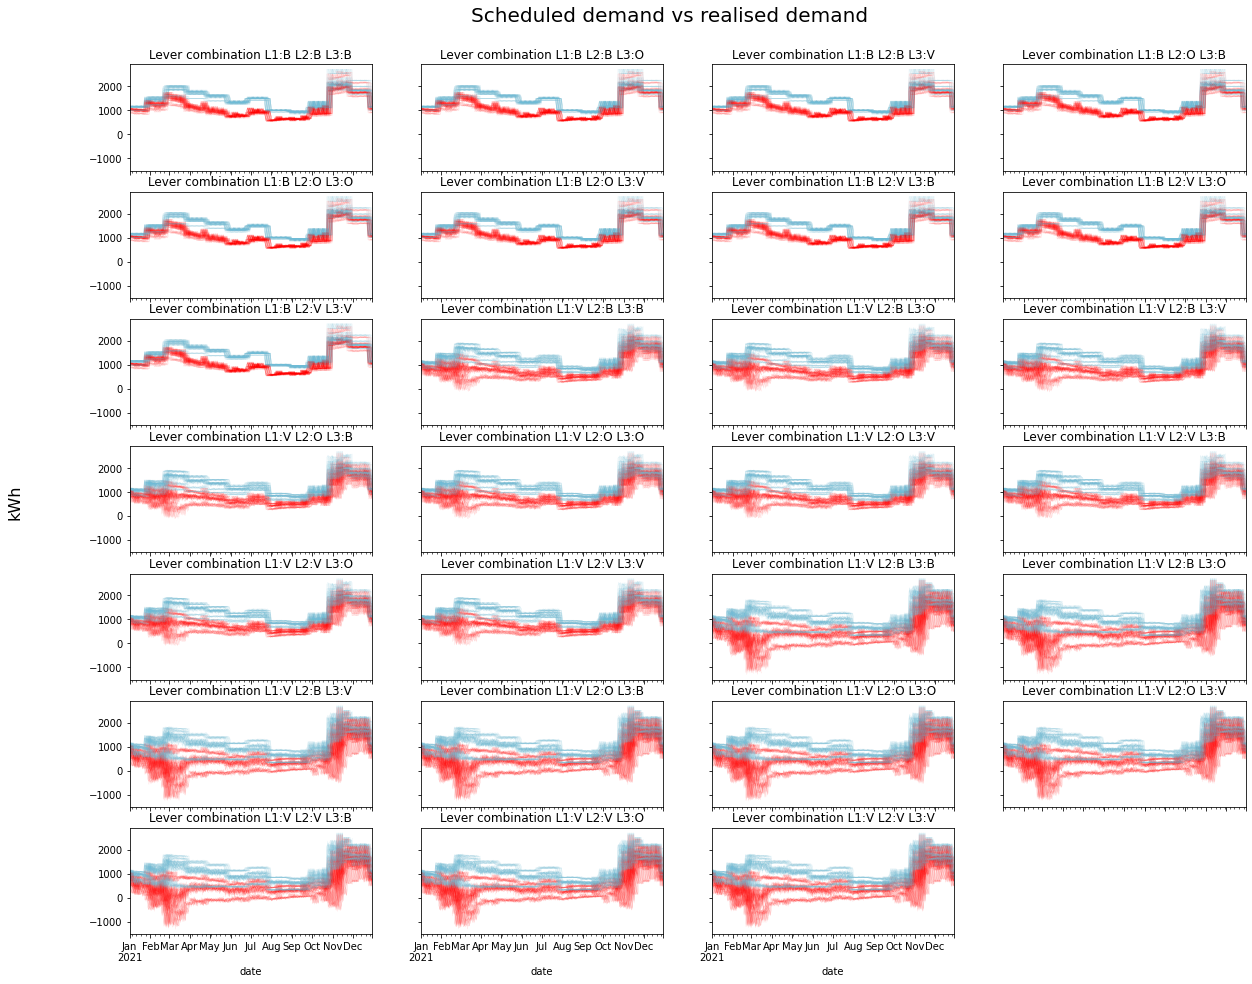

In [32]:
rows = 7
columns = 4
fig, axs = plt.subplots(rows, columns, sharey=True, sharex=True, figsize=(20, 16))
fig.suptitle('Scheduled demand vs realised demand', fontsize=20, y=0.93)
# fig.text(0.5, 0.04, 'Year', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'kWh', va='center', rotation='vertical', fontsize=16)

# Create index of list of indices for axes
axs_index = []
for i in range(rows):  # iterate through the rows of the subplot grid
    for j in range(columns):  # iterate through the columns of the subplot grid
        axs_index.append(axs[i, j])
axs_index = axs_index[:-1]  # remove last axis as it is not needed

# lever combination number is the unique combination of policy scenarios
lever_combination_number = 0

# iterate through the columns and rows of the subplot grid
for ax in axs_index:
    corresponding_experiments = same_levers[
        lever_combination_number]  # List of experiment index having same lever combination
    for experiment_index in corresponding_experiments:  # iterate through the experiments having same lever combination
        experiment_results = separated_results[
            experiment_index]  # Get results of experiment with index experiment_index
        for result in experiment_results:  # iterate through the simulation runs of experiment with index experiment_index
            realised_demand = extract_df_from_json(result, 'M1: realised_demand')
            realised_demand['date'] = pd.to_datetime(realised_demand['date'], format='%Y-%m-%d')
            realised_demand.set_index('date', inplace=True, drop=True)
            scheduled_demand = extract_df_from_json(result, 'M2: scheduled_demand')
            scheduled_demand['date'] = pd.to_datetime(scheduled_demand['date'], format='%Y-%m-%d')
            scheduled_demand.set_index('date', inplace=True, drop=True)
            # collect results for residential and non-residential community members separately
            residential = realised_demand.columns.to_list()[:-2]
            non_residential = realised_demand.columns.to_list()[-2:]
            # calculate total results for residential and non-residential community members
            realised_demand['residential'] = realised_demand.loc[:, residential].sum(axis=1)
            scheduled_demand['residential'] = scheduled_demand.loc[:, residential].sum(axis=1)
            # remove unwanted columns
            columns_to_keep = ['residential']
            realised_demand = realised_demand[columns_to_keep]
            scheduled_demand = scheduled_demand[columns_to_keep]

            # plot results for residential and non-residential community members
            scheduled_demand[['residential']].plot(ax=ax, color='#6ebbd5', legend=False, linewidth=0.2, alpha=0.3)
            realised_demand[['residential']].plot(ax=ax, colormap='hsv', legend=False, linewidth=0.2, alpha=0.2)
            ax.set_title(f"Lever combination {unique_levers.loc[lever_combination_number, 'lever information']}",
                         fontsize=12)
    lever_combination_number += 1

# remove last axis as it is not needed
axs[6, 3].axis('off')

plt.savefig('figures/gridflex/Scheduled demand vs realised demand residential.png')

Scheduled demand vs realised demand for residential community members

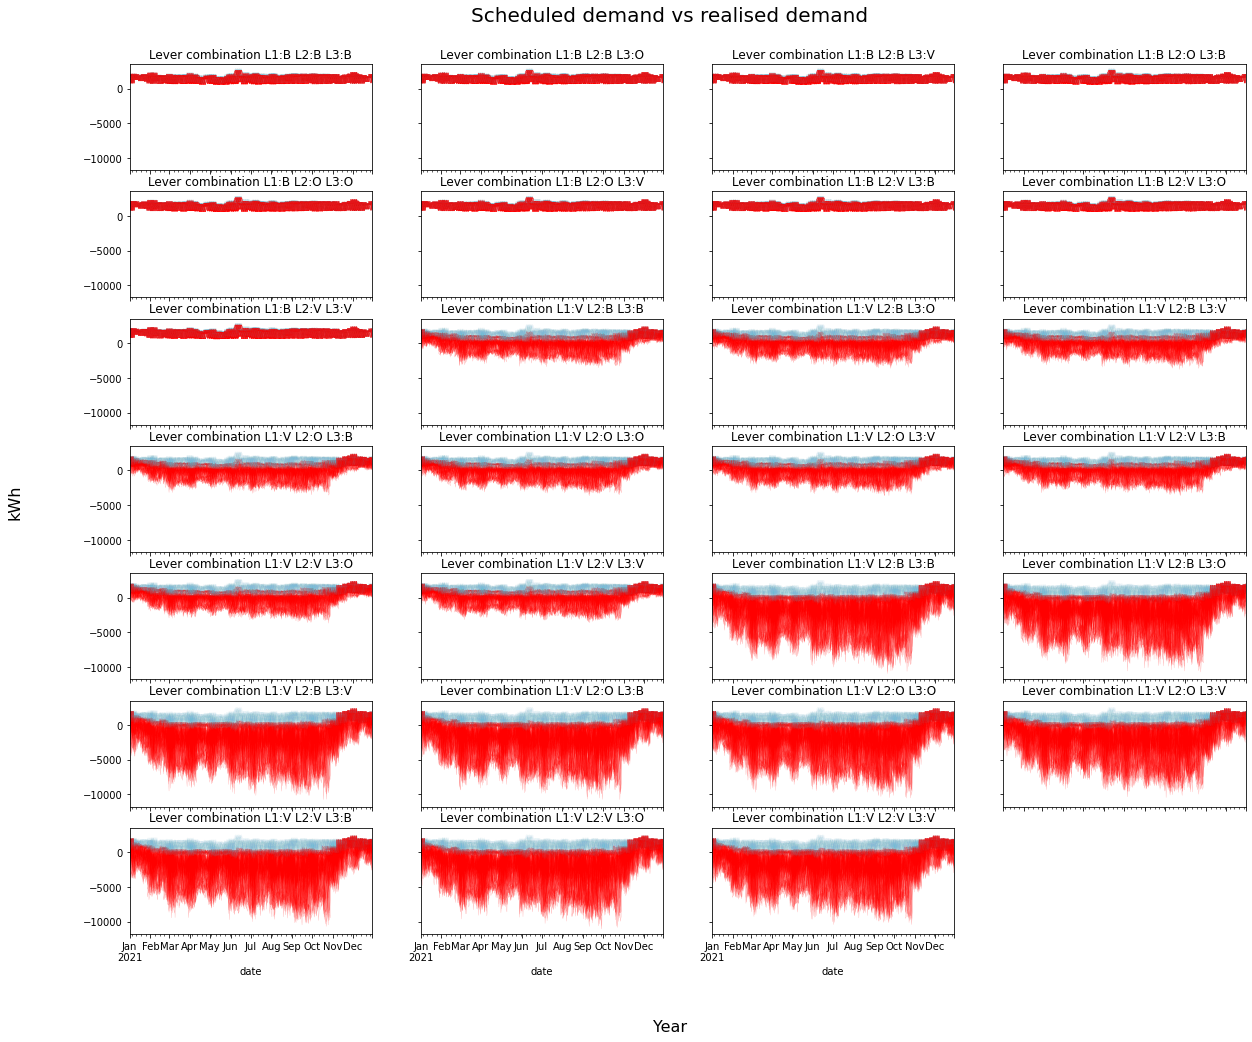

In [33]:
rows = 7
columns = 4
fig, axs = plt.subplots(rows, columns, sharey=True, sharex=True, figsize=(20, 16))
fig.suptitle('Scheduled demand vs realised demand', fontsize=20, y=0.93)
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'kWh', va='center', rotation='vertical', fontsize=16)

# Create index of list of indices for axes
axs_index = []
for i in range(rows):  # iterate through the rows of the subplot grid
    for j in range(columns):  # iterate through the columns of the subplot grid
        axs_index.append(axs[i, j])
axs_index = axs_index[:-1]  # remove last axis as it is not needed

# lever combination number is the unique combination of policy scenarios
lever_combination_number = 0

# iterate through the columns and rows of the subplot grid
for ax in axs_index:
    corresponding_experiments = same_levers[
        lever_combination_number]  # List of experiment index having same lever combination
    for experiment_index in corresponding_experiments:  # iterate through the experiments having same lever combination
        experiment_results = separated_results[
            experiment_index]  # Get results of experiment with index experiment_index
        for result in experiment_results:  # iterate through the simulation runs of experiment with index experiment_index
            realised_demand = extract_df_from_json(result, 'M1: realised_demand')
            realised_demand['date'] = pd.to_datetime(realised_demand['date'], format='%Y-%m-%d')
            realised_demand.set_index('date', inplace=True, drop=True)
            scheduled_demand = extract_df_from_json(result, 'M2: scheduled_demand')
            scheduled_demand['date'] = pd.to_datetime(scheduled_demand['date'], format='%Y-%m-%d')
            scheduled_demand.set_index('date', inplace=True, drop=True)
            # collect results for residential and non-residential community members separately
            residential = realised_demand.columns.to_list()[:-2]
            non_residential = realised_demand.columns.to_list()[-2:]
            # calculate total results for residential and non-residential community members
            realised_demand['non_residential'] = realised_demand.loc[:, non_residential].sum(axis=1)
            scheduled_demand['non_residential'] = scheduled_demand.loc[:, non_residential].sum(axis=1)
            # remove unwanted columns
            columns_to_keep = ['non_residential']
            realised_demand = realised_demand[columns_to_keep]
            scheduled_demand = scheduled_demand[columns_to_keep]

            # plot results for residential and non-residential community members
            scheduled_demand[['non_residential']].plot(ax=ax, color='#6ebbd5', legend=False, linewidth=0.2, alpha=0.1)
            realised_demand[['non_residential']].plot(ax=ax, colormap='hsv', legend=False, linewidth=0.2, alpha=0.5)
            ax.set_title(f"Lever combination {unique_levers.loc[lever_combination_number, 'lever information']}",
                         fontsize=12)
    lever_combination_number += 1

# remove last axis as it is not needed
axs[6, 3].axis('off')

plt.savefig('figures/gridflex/Scheduled demand vs realised demand nonresidential.png')

## Plotting shifted load curves

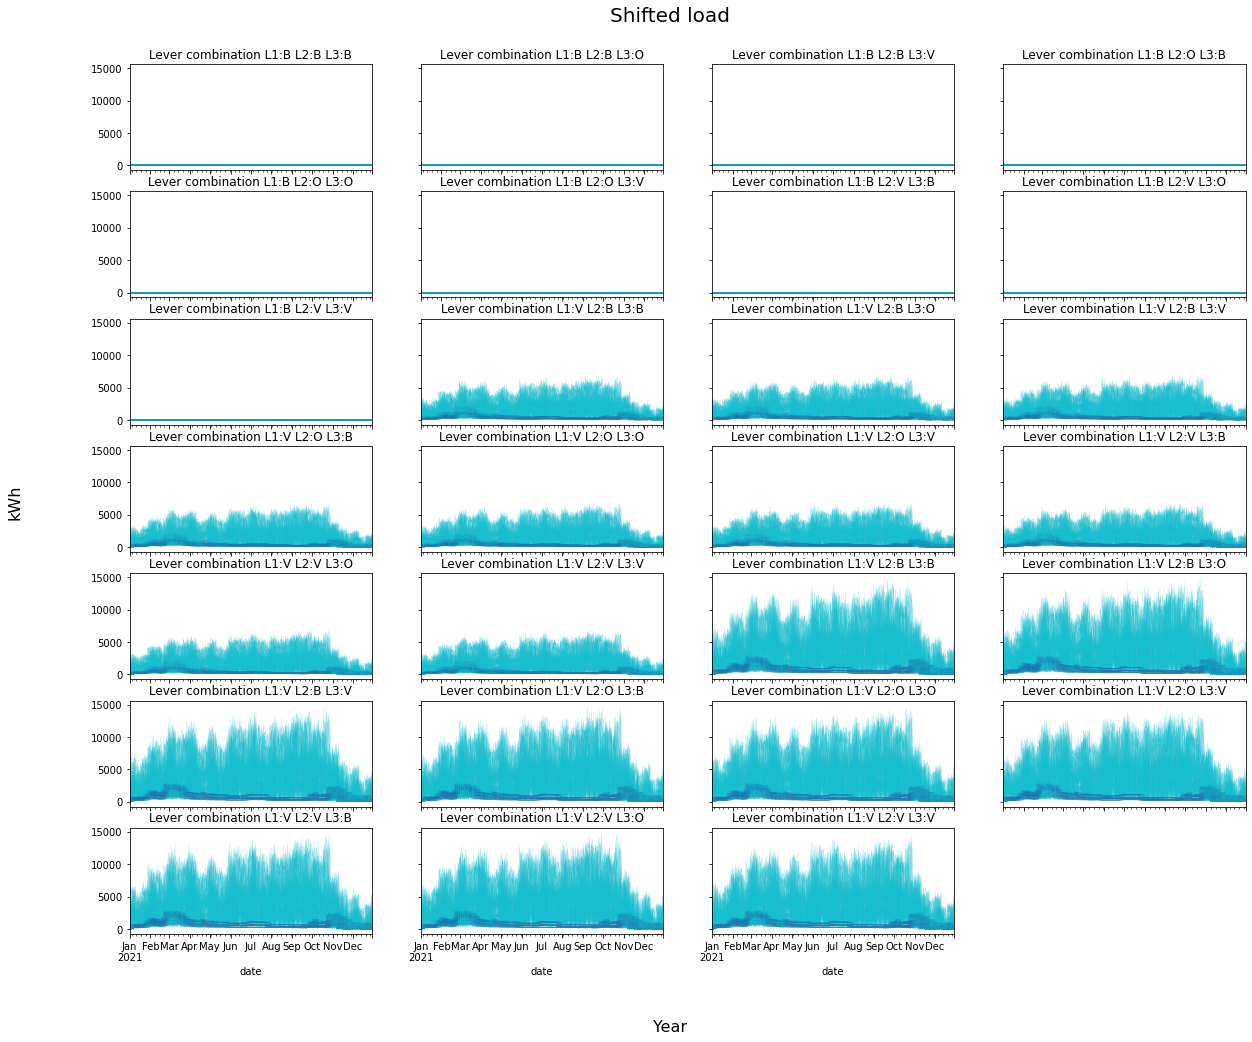

In [34]:
rows = 7
columns = 4
fig, axs = plt.subplots(rows, columns, sharey=True, sharex=True, figsize=(20, 16))
fig.suptitle('Shifted load', fontsize=20, y=0.93)
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'kWh', va='center', rotation='vertical', fontsize=16)

# Create index of list of indices for axes
axs_index = []
for i in range(rows):  # iterate through the rows of the subplot grid
    for j in range(columns):  # iterate through the columns of the subplot grid
        axs_index.append(axs[i, j])
axs_index = axs_index[:-1]  # remove last axis as it is not needed

# lever combination number is the unique combination of policy scenarios
lever_combination_number = 0

# iterate through the columns and rows of the subplot grid
for ax in axs_index:
    corresponding_experiments = same_levers[
        lever_combination_number]  # List of experiment index having same lever combination
    for experiment_index in corresponding_experiments:  # iterate through the experiments having same lever combination
        experiment_results = separated_results[
            experiment_index]  # Get results of experiment with index experiment_index
        for result in experiment_results:  # iterate through the simulation runs of experiment with index experiment_index
            shifted_load = extract_df_from_json(result, 'M3: shifted_load')
            shifted_load['date'] = pd.to_datetime(shifted_load['date'], format='%Y-%m-%d')
            shifted_load.set_index('date', inplace=True, drop=True)
            # collect results for residential and non-residential community members separately
            residential = shifted_load.columns.to_list()[:-2]
            non_residential = shifted_load.columns.to_list()[-2:]
            # calculate total results for residential and non-residential community members
            shifted_load['residential'] = shifted_load.loc[:, residential].sum(axis=1)
            shifted_load['non_residential'] = shifted_load.loc[:, non_residential].sum(axis=1)
            # remove unwanted columns
            columns_to_keep = ['residential', 'non_residential']
            shifted_load = shifted_load[columns_to_keep]

            # plot results for community members
            shifted_load.plot(ax=ax, colormap='tab10', legend=False, linewidth=0.2, alpha=0.5)
            ax.set_title(f"Lever combination {unique_levers.loc[lever_combination_number, 'lever information']}",
                         fontsize=12)
    lever_combination_number += 1

# remove last axis as it is not needed
axs[6, 3].axis('off')

plt.savefig('figures/gridflex/shifted_load.png', dpi=300)

## Energy cost and savings through demand response

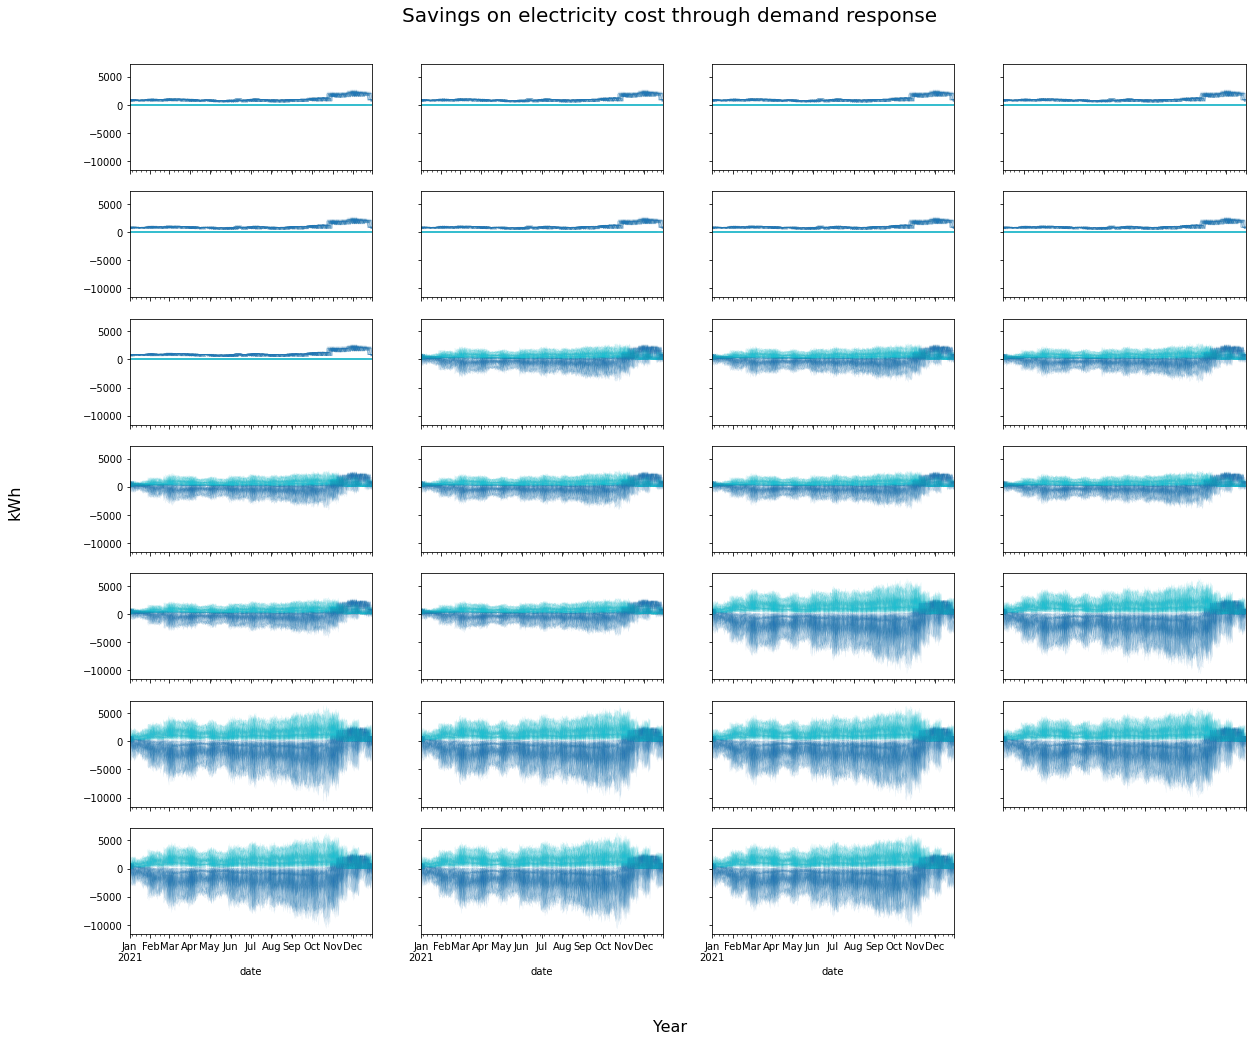

In [35]:
rows = 7
columns = 4
fig, axs = plt.subplots(rows, columns, sharey=True, sharex=True, figsize=(20, 16))
fig.suptitle('Savings on electricity cost through demand response', fontsize=20, y=0.93)
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'kWh', va='center', rotation='vertical', fontsize=16)

# Create index of list of indices for axes
axs_index = []
for i in range(rows):  # iterate through the rows of the subplot grid
    for j in range(columns):  # iterate through the columns of the subplot grid
        axs_index.append(axs[i, j])
axs_index = axs_index[:-1]  # remove last axis as it is not needed

# lever combination number is the unique combination of policy scenarios
lever_combination_number = 0

# iterate through the columns and rows of the subplot grid
for ax in axs_index:
    corresponding_experiments = same_levers[
        lever_combination_number]  # List of experiment index having same lever combination
    for experiment_index in corresponding_experiments:  # iterate through the experiments having same lever combination
        experiment_results = separated_results[
            experiment_index]  # Get results of experiment with index experiment_index
        for result in experiment_results:  # iterate through the simulation runs of experiment with index experiment_index

            savings = extract_df_from_json(result, 'M5: savings_on_ToD')
            savings['date'] = pd.to_datetime(savings['date'], format='%Y-%m-%d')
            savings.set_index('date', inplace=True, drop=True)

            costs = extract_df_from_json(result, 'M6: energy_costs')
            costs['date'] = pd.to_datetime(costs['date'], format='%Y-%m-%d')
            costs.set_index('date', inplace=True, drop=True)

            # collect results for residential and non-residential community members separately
            residential = savings.columns.to_list()[:-2]
            non_residential = savings.columns.to_list()[-2:]

            # calculate total results for residential and non-residential community members
            costs['costs'] = costs.sum(axis=1)
            costs['savings'] = savings.sum(axis=1)

            columns_to_keep = ['costs', 'savings']
            costs = costs[columns_to_keep]

            # plot results
            costs.plot(ax=ax,colormap = 'tab10', legend=False, linewidth=0.2, alpha=0.2)
    lever_combination_number += 1
# remove last axis as it is not needed
axs[6, 3].axis('off')

plt.savefig('figures/gridflex/savings.png', dpi=300)

## Plotting generation from community assets

ValueError: When stacked is True, each column must be either all positive or all negative. Column 'non_residential' contains both positive and negative values

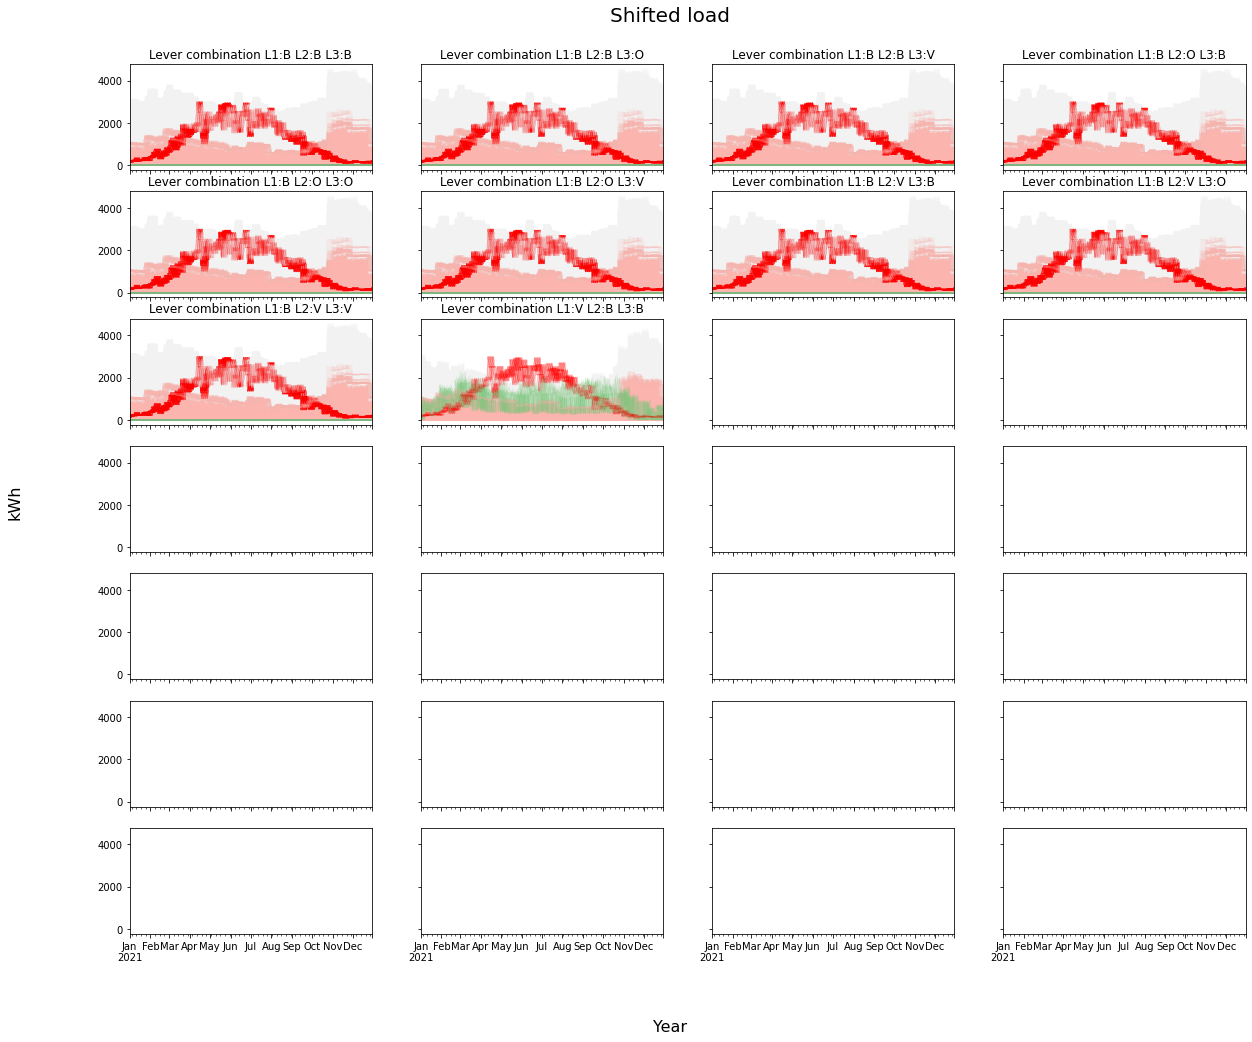

In [36]:
rows = 7
columns = 4
fig, axs = plt.subplots(rows, columns, sharey=True, sharex=True, figsize=(20, 16))
fig.suptitle('Shifted load', fontsize=20, y=0.93)
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'kWh', va='center', rotation='vertical', fontsize=16)

# Create index of list of indices for axes
axs_index = []
for i in range(rows):  # iterate through the rows of the subplot grid
    for j in range(columns):  # iterate through the columns of the subplot grid
        axs_index.append(axs[i, j])
axs_index = axs_index[:-1]  # remove last axis as it is not needed

# lever combination number is the unique combination of policy scenarios
lever_combination_number = 0

# iterate through the columns and rows of the subplot grid
for ax in axs_index:
    corresponding_experiments = same_levers[
        lever_combination_number]  # List of experiment index having same lever combination
    for experiment_index in corresponding_experiments:  # iterate through the experiments having same lever combination
        experiment_results = separated_results[
            experiment_index]  # Get results of experiment with index experiment_index
        for result in experiment_results:  # iterate through the simulation runs of experiment with index experiment_index

            realised_demand = extract_df_from_json(result, 'M1: realised_demand')
            realised_demand['date'] = pd.to_datetime(realised_demand['date'], format='%Y-%m-%d')
            realised_demand.set_index('date', inplace=True, drop=True)

            generation = extract_df_from_json(result, 'M4: total_generation')
            generation['date'] = pd.to_datetime(generation['date'], format='%Y-%m-%d')
            generation.set_index('date', inplace=True, drop=True)

            shifted_load = extract_df_from_json(result, 'M3: shifted_load')
            shifted_load['date'] = pd.to_datetime(shifted_load['date'], format='%Y-%m-%d')
            shifted_load.set_index('date', inplace=True, drop=True)

            # collect results for residential and non-residential community members separately
            residential = realised_demand.columns.to_list()[:-2]
            non_residential = realised_demand.columns.to_list()[-2:]

            # calculate total results for residential and non-residential community members
            realised_demand['residential'] = realised_demand.loc[:, residential].sum(axis=1)
            realised_demand['non_residential'] = realised_demand.loc[:, non_residential].sum(axis=1)

            shifted_load['total_shifted_load'] = shifted_load.sum(axis=1)
            shifted_load = shifted_load['total_shifted_load']

            columns_to_keep = ['residential', 'non_residential']
            realised_demand = realised_demand[columns_to_keep]

            # plot results for community members
            realised_demand.plot(ax=ax, colormap='Pastel1', kind="area", stacked=True, legend=False, linewidth=0.2,
             alpha=0.5)
            generation.plot(ax=ax, colormap = 'hsv', legend=False, linewidth=0.2, alpha=0.5)
            shifted_load.plot(ax=ax, colormap = 'Accent', legend=False, linewidth=0.2, alpha=0.5)
            ax.set_title(f"Lever combination {unique_levers.loc[lever_combination_number, 'lever information']}",
                         fontsize=12)


    lever_combination_number += 1

# remove last axis as it is not needed
axs[6, 3].axis('off')

plt.savefig('figures/gridflex/generation.png', dpi=300)